Use `c2gsea` environment here

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import anndata as ad
import gseapy as gp

import re
from collections import defaultdict
import pickle
import glob
import pickle
import gc

ModuleNotFoundError: No module named 'gseapy'

In [21]:
def collect():
    gc.collect()

### Let's implement the idea of randomly sampling certain number of cells to compare validity of scGSEA method

General idea:
1. For each group, randomly sample N cells and their scGSEA output 
2. Compare the random sample to the pseudobulk results which we obtained earlier for that specific group and calculate significance
3. Probably repeat a few times and then plot comparing analysis with our scGSEA results for the actual group of cells

In [ ]:
with open("/home/ddz5/Desktop/c2s-RL/gene_programs_dev/gene_set_data/local(69)/top_gene_programs.csv")

In [2]:
# recall, our inference runs already have stored the outputs of our scGSEA model
with open("/home/ddz5/scratch/Cell2GSEA_QA_dataset_models/finished_datasets/local(83)/output_scores.pickle", "rb") as f:
    output_scores = pickle.load(f)

In [3]:
output_scores.shape

(31230, 33435)

In [4]:
train_input_path = "/home/ddz5/scratch/Cell2GSEA_QA_dataset_models/finished_datasets/local(83)/new_training_inputs.pickle"

with open(train_input_path, 'rb') as f:
    train_inputs = pickle.load(f)

In [25]:
for key in train_inputs.keys():
    print(key)

input_gene_set_csv_path
input_h5ad_file_path
gene_set_names
gene_set_sizes
gene_names
cell_ids
extra
cell_types
disease
train_x_sparse
train_edges
progs_sparse
prog_clusters


In [28]:
train_inputs['gene_se']

['chr12q15',
 'chr13q12',
 'chr13q14',
 'chr13q32',
 'chr19p12',
 'chr19p13',
 'chr19q13',
 'chr1p35',
 'chr20q11',
 'chr2p23',
 'chr3p23',
 'chr4p11',
 'chr6p11',
 'chr6q15',
 'chr9p13',
 'chr9p21',
 'chr9q32',
 'chr9q33',
 'ABBUD_LIF_SIGNALING_1_DN',
 'ABBUD_LIF_SIGNALING_1_UP',
 'ABBUD_LIF_SIGNALING_2_DN',
 'ABBUD_LIF_SIGNALING_2_UP',
 'ABDELMOHSEN_ELAVL4_TARGETS',
 'ABDULRAHMAN_KIDNEY_CANCER_VHL_DN',
 'ABE_INNER_EAR',
 'ABE_VEGFA_TARGETS',
 'ABE_VEGFA_TARGETS_2HR',
 'ABE_VEGFA_TARGETS_30MIN',
 'ABRAHAM_ALPC_VS_MULTIPLE_MYELOMA_DN',
 'ABRAHAM_ALPC_VS_MULTIPLE_MYELOMA_UP',
 'ABRAMSON_INTERACT_WITH_AIRE',
 'ACEVEDO_LIVER_CANCER_DN',
 'ACEVEDO_LIVER_CANCER_UP',
 'ACEVEDO_LIVER_CANCER_WITH_H3K27ME3_UP',
 'ACEVEDO_LIVER_CANCER_WITH_H3K9ME3_UP',
 'ACEVEDO_LIVER_TUMOR_VS_NORMAL_ADJACENT_TISSUE_DN',
 'ACEVEDO_LIVER_TUMOR_VS_NORMAL_ADJACENT_TISSUE_UP',
 'ACEVEDO_METHYLATED_IN_LIVER_CANCER_DN',
 'ACEVEDO_NORMAL_TISSUE_ADJACENT_TO_LIVER_TUMOR_DN',
 'ACEVEDO_NORMAL_TISSUE_ADJACENT_TO_LIVER_TUMO

In [6]:
output_scores

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
np.array(output_scores).dtype

dtype('float64')

In [17]:
output_scores = np.array(output_scores)

In [20]:
output_scores_df = pd.DataFrame(output_scores)

In [18]:
print(type(output_scores))                      # Should be <class 'numpy.ndarray'>
print(output_scores.dtype)                      # Should be float64 ideally
print(output_scores.shape)                      # Should be (n_cells, n_programs)
print(output_scores[0])                         # Should be a 1D float array
print(type(output_scores[0]))                   # If this is still ndarray — you're in trouble!

<class 'numpy.ndarray'>
float64
(31230, 33435)
[0. 0. 0. ... 0. 0. 0.]
<class 'numpy.ndarray'>


In [23]:
output_scores_df = pd.DataFrame(np.vstack(output_scores))

In [19]:
# output_scores_df = pd.DataFrame(output_scores, columns=train_inputs['gene_set_names'])
output_scores_df['cell_type'] = train_inputs['cell_types']
output_scores_df['disease'] = train_inputs['disease']

ValueError: Length of values (8114) does not match length of index (31230)

### Basic analysis of results

In [16]:
results_dir = "/home/ddz5/Desktop/c2s-RL/gene_programs_dev/gene_set_data"

dataset_names = []
for d in os.listdir(results_dir):
    if re.match(r"local\(\d+\)", d):
        csv_file_path = os.path.join(results_dir, d, f"{d}_comparison_results.csv")
        
        # Only include dataset if the CSV file exists
        if os.path.isfile(csv_file_path):
            dataset_names.append(d)

In [8]:
# let's first load in a sample .csv results file
pd.read_csv(os.path.join(results_dir, dataset_names[0], f"{dataset_names[0]}_comparison_results.csv"))

,dataset,cell_type,condition,ES,NES,p_value,n_ref,depth_50pct,depth_70pct,depth_90pct,depth_99pct
0,local(6),P/D1 enteroendocrine cell,Barrett esophagus,24.033775,0.250456,0.950,100,20150,22300,-1,-1
1,local(6),enterocyte,Barrett esophagus,648.598873,6.888109,0.000,100,3413,7301,-1,-1
2,local(6),enteroendocrine cell,Barrett esophagus,460.163824,4.852813,0.000,100,6202,13786,23072,-1
3,local(6),foveolar cell of stomach,Barrett esophagus,550.116564,5.706012,0.000,100,6289,8746,-1,-1
4,local(6),intestine goblet cell,Barrett esophagus,329.344906,3.507435,0.000,100,7196,13205,-1,-1
5,local(6),mucous neck cell,Barrett esophagus,447.051916,4.694091,0.000,100,5912,10001,22285,-1
6,local(6),parietal cell,Barrett esophagus,353.839878,3.741814,0.000,100,9308,16523,-1,-1
7,local(6),peptic cell,Barrett esophagus,225.386205,2.333154,0.022,100,9076,15069,-1,-1
8,local(6),stem cell,Barrett esophagus,471.970725,4.996868,0.000,100,6127,9746,22267,-1
9,local(6),P/D1 enteroendocrine cell,gastritis,36.203965,0.384262,0.893,100,22382,23062,23737,-1


Let's compile the results together, plot the distribution of average p-values across datasets as well as some average recovery depth curve

In [17]:
# merging all datasets together
df_list = [pd.read_csv(os.path.join(results_dir, dataset_name, f"{dataset_name}_comparison_results.csv")) for dataset_name in dataset_names]

In [20]:
combined_df = pd.concat(df_list, ignore_index=True)
combined_df.to_csv(os.path.join(os.getcwd(), "gene_set_data", "meta_gsea_combined_summary.csv"), index=False)

In [41]:
# drop 'local(192)' - seems like a lot of the gene sets we detected were not found in the gseapy analysis 
# as well as 'local(143)' 
combined_df[(combined_df['dataset'] == 'local(192)') | (combined_df['dataset'] == 'local(143)')]
new_combined_df = combined_df[(combined_df['dataset'] != 'local(192)') & (combined_df['dataset'] != 'local(143)')]

In [42]:
new_combined_df

,dataset,cell_type,condition,ES,NES,p_value,n_ref,depth_50pct,depth_70pct,depth_90pct,depth_99pct
0,local(6),P/D1 enteroendocrine cell,Barrett esophagus,24.033775,0.250456,0.950,100,20150,22300,-1,-1
1,local(6),enterocyte,Barrett esophagus,648.598873,6.888109,0.000,100,3413,7301,-1,-1
2,local(6),enteroendocrine cell,Barrett esophagus,460.163824,4.852813,0.000,100,6202,13786,23072,-1
3,local(6),foveolar cell of stomach,Barrett esophagus,550.116564,5.706012,0.000,100,6289,8746,-1,-1
4,local(6),intestine goblet cell,Barrett esophagus,329.344906,3.507435,0.000,100,7196,13205,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...
698,local(479),mature NK T cell,normal,357.597673,3.792918,0.000,100,7305,12354,20774,-1
699,local(479),B cell,normal,222.433818,2.355769,0.020,100,9090,16840,21481,-1
700,local(479),cholangiocyte,normal,227.494375,2.376403,0.011,100,9044,13714,20480,-1
701,local(479),hepatocyte,normal,283.082531,2.973839,0.002,100,9067,12537,21513,-1


/tmp/tmp.rqE7CWxLfF/ipykernel_3964137/4227356147.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=new_combined_df, x="p_value", hue="dataset", common_norm=False, alpha=0.4, legend=False)


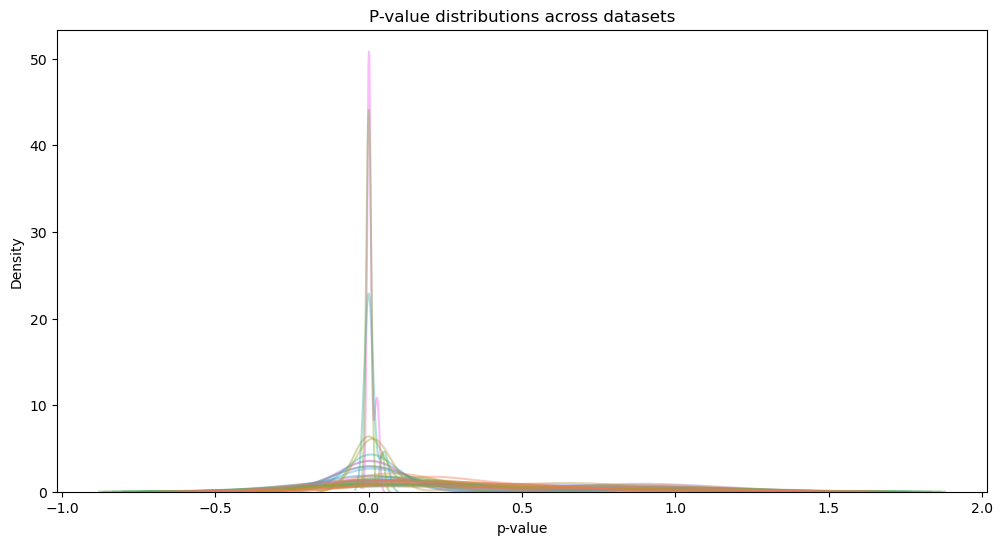

In [43]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=new_combined_df, x="p_value", hue="dataset", common_norm=False, alpha=0.4, legend=False)
plt.title("P-value distributions across datasets")
plt.xlabel("p-value")
plt.ylabel("Density")
plt.show()

/tmp/tmp.rqE7CWxLfF/ipykernel_3964137/3354461590.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=signif_summary, x="dataset", y="prop_significant", palette="coolwarm")


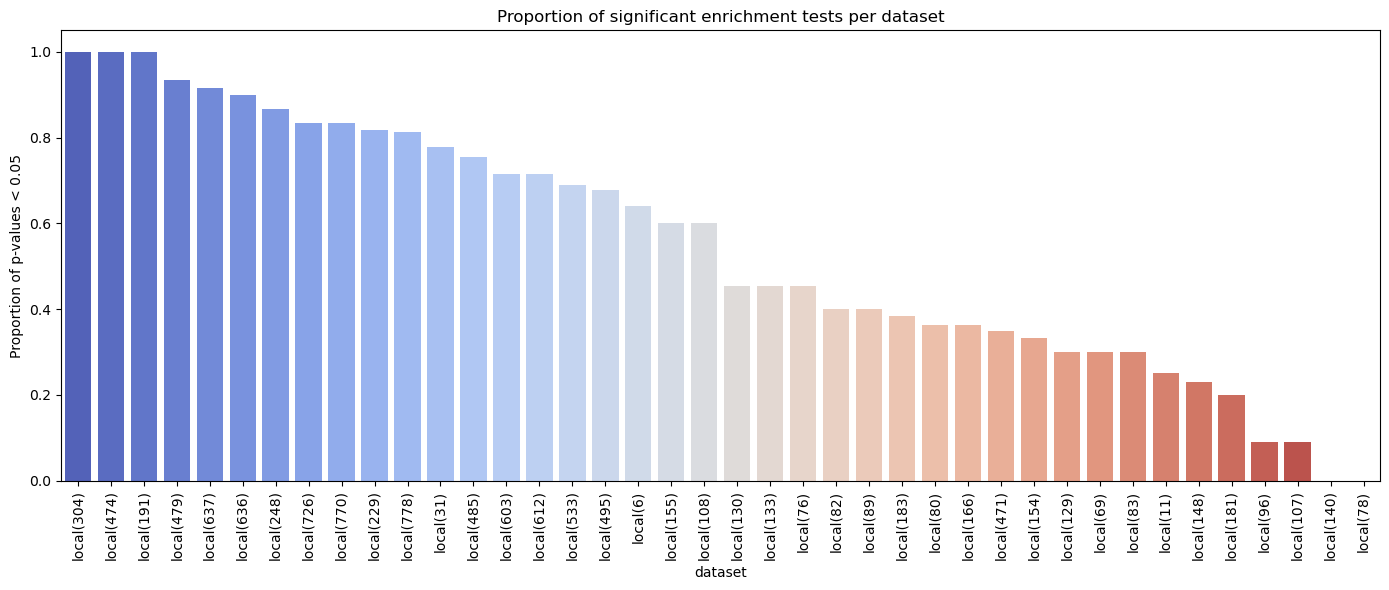

In [48]:
# hm, this doesn't to be that insightful. ~40 ish datasets each with at least like 10 p-values. maybe we can plot proportion of groups within each dataset are significant 

signif_summary = new_combined_df.groupby("dataset")["p_value"].apply(lambda x: (x < 0.05).mean()).reset_index()
signif_summary.columns = ["dataset", "prop_significant"]
signif_summary = signif_summary.sort_values(by="prop_significant", ascending=False)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=signif_summary, x="dataset", y="prop_significant", palette="coolwarm")
plt.xticks(rotation=90)
plt.ylabel("Proportion of p-values < 0.05")
plt.ylim(0, 1.05)
plt.title("Proportion of significant enrichment tests per dataset")
plt.tight_layout()
plt.show()

/tmp/tmp.rqE7CWxLfF/ipykernel_3964137/661818432.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=signif_summary, x="dataset", y="prop_significant", palette="coolwarm")


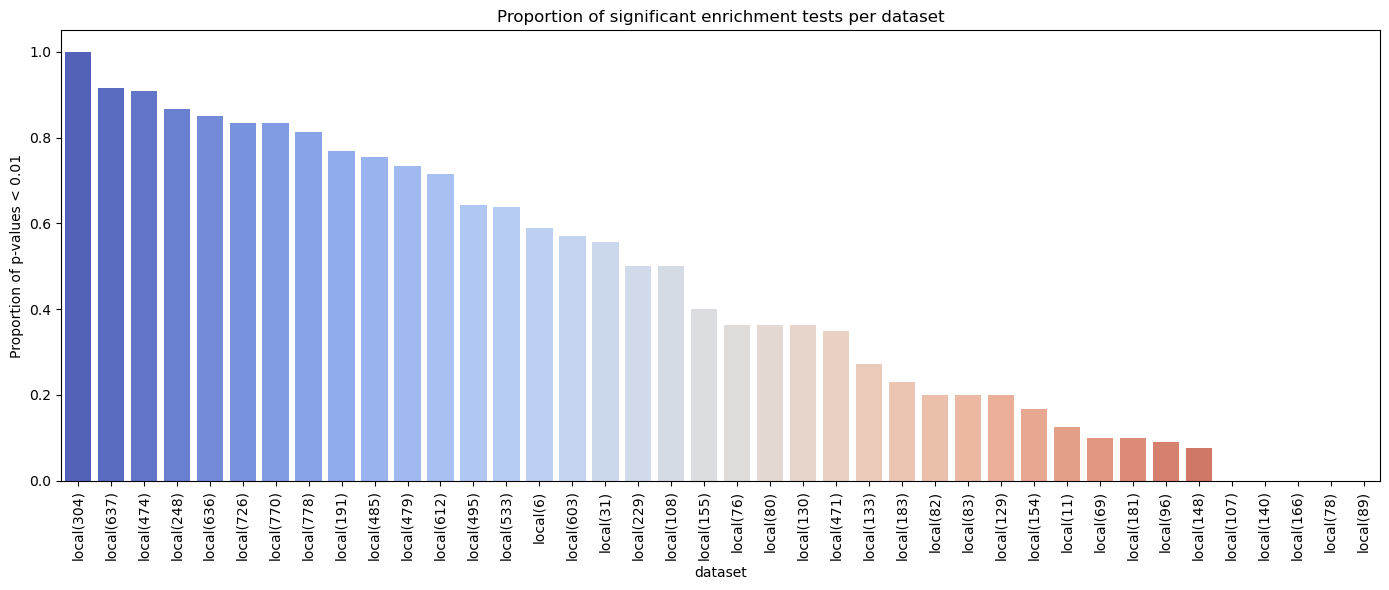

In [47]:
# hm, this doesn't to be that insightful. ~40 ish datasets each with at least like 10 p-values. maybe we can plot proportion of groups within each dataset are significant 

signif_summary = new_combined_df.groupby("dataset")["p_value"].apply(lambda x: (x < 0.01).mean()).reset_index()
signif_summary.columns = ["dataset", "prop_significant"]
signif_summary = signif_summary.sort_values(by="prop_significant", ascending=False)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=signif_summary, x="dataset", y="prop_significant", palette="coolwarm")
plt.xticks(rotation=90)
plt.ylabel("Proportion of p-values < 0.01")
plt.ylim(0, 1.05)
plt.title("Proportion of significant enrichment tests per dataset")
plt.tight_layout()
plt.show()

In [49]:
# now let's plot recovery depth
new_combined_df

,dataset,cell_type,condition,ES,NES,p_value,n_ref,depth_50pct,depth_70pct,depth_90pct,depth_99pct
0,local(6),P/D1 enteroendocrine cell,Barrett esophagus,24.033775,0.250456,0.950,100,20150,22300,-1,-1
1,local(6),enterocyte,Barrett esophagus,648.598873,6.888109,0.000,100,3413,7301,-1,-1
2,local(6),enteroendocrine cell,Barrett esophagus,460.163824,4.852813,0.000,100,6202,13786,23072,-1
3,local(6),foveolar cell of stomach,Barrett esophagus,550.116564,5.706012,0.000,100,6289,8746,-1,-1
4,local(6),intestine goblet cell,Barrett esophagus,329.344906,3.507435,0.000,100,7196,13205,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...
698,local(479),mature NK T cell,normal,357.597673,3.792918,0.000,100,7305,12354,20774,-1
699,local(479),B cell,normal,222.433818,2.355769,0.020,100,9090,16840,21481,-1
700,local(479),cholangiocyte,normal,227.494375,2.376403,0.011,100,9044,13714,20480,-1
701,local(479),hepatocyte,normal,283.082531,2.973839,0.002,100,9067,12537,21513,-1


In [51]:
depths_long

,dataset,cell_type,condition,recovery_target,depth
0,local(6),P/D1 enteroendocrine cell,Barrett esophagus,50%,20150
1,local(6),enterocyte,Barrett esophagus,50%,3413
2,local(6),enteroendocrine cell,Barrett esophagus,50%,6202
3,local(6),foveolar cell of stomach,Barrett esophagus,50%,6289
4,local(6),intestine goblet cell,Barrett esophagus,50%,7196
...,...,...,...,...,...
2807,local(479),mature NK T cell,normal,99%,-1
2808,local(479),B cell,normal,99%,-1
2809,local(479),cholangiocyte,normal,99%,-1
2810,local(479),hepatocyte,normal,99%,-1


/tmp/tmp.rqE7CWxLfF/ipykernel_3964137/145367896.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=depths_long, x="recovery_target", y="depth", palette="mako")


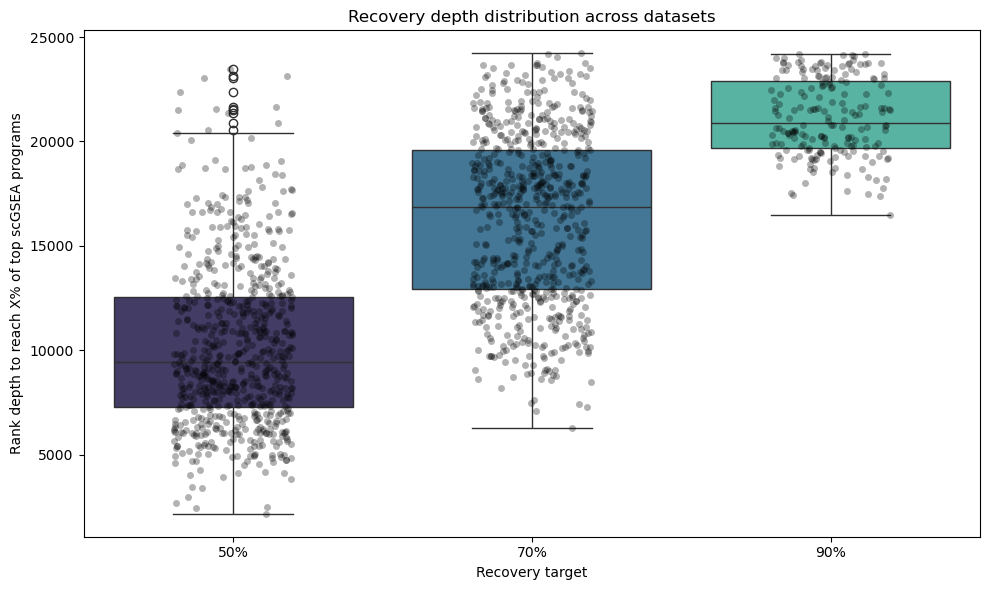

In [57]:
# Melt the DataFrame
depths_long = new_combined_df.melt(
    id_vars=["dataset", "cell_type", "condition"],
    value_vars=["depth_50pct", "depth_70pct", "depth_90pct"],  # skip 99% if noisy
    var_name="recovery_target",
    value_name="depth"
)

# Clean up labels
depths_long["recovery_target"] = depths_long["recovery_target"].str.replace("depth_", "").str.replace("pct", "%")

# Filter out -1 values (unrecovered)
depths_long = depths_long[depths_long["depth"] != -1]

# Plot recovery depth distributions
plt.figure(figsize=(10, 6))
sns.boxplot(data=depths_long, x="recovery_target", y="depth", palette="mako")
sns.stripplot(data=depths_long, x="recovery_target", y="depth", color='black', alpha=0.3, jitter=0.2)

# plt.yscale("log")  # If depths span wide range
plt.ylabel("Rank depth to reach X% of top scGSEA programs")
plt.xlabel("Recovery target")
plt.title("Recovery depth distribution across datasets")
plt.tight_layout()
plt.show()


In [54]:
avg_recovery

,dataset,depth_50pct,depth_70pct,depth_90pct
0,local(107),12042.000000,17357.750000,22813.500000
1,local(181),12272.000000,16226.000000,24121.500000
2,local(191),8661.846154,13524.461538,19650.076923
3,local(229),9518.318182,14262.545455,20307.363636
4,local(471),11317.555556,15680.000000,21832.222222
5,local(474),7553.200000,13370.600000,21707.400000
6,local(479),8436.307692,13092.461538,21217.615385
7,local(533),9122.692308,14276.192308,22746.038462
8,local(6),9823.928571,14244.642857,23297.857143
9,local(603),9730.285714,14286.428571,20585.000000


In [58]:
# recovery_cols = ["depth_50pct", "depth_70pct", "depth_90pct"]
# # drop any datasets where the recovery depth at certain percentage is -1
# # Columns of interest
# recovery_cols = ["depth_50pct", "depth_70pct", "depth_90pct"]

# # Replace -1 with NaN so they’re ignored in mean()
# depth_df = combined_df[["dataset"] + recovery_cols].copy()
# depth_df[recovery_cols] = depth_df[recovery_cols].replace(-1, np.nan)

# # Group by dataset, calculate mean depth while ignoring NaNs
# avg_recovery = depth_df.groupby("dataset")[recovery_cols].mean().reset_index()

# # Drop datasets that are completely missing (all NaN) across all targets
# avg_recovery = avg_recovery.dropna(how="all", subset=recovery_cols)

# # Melt for plotting
# avg_recovery_long = avg_recovery.melt(
#     id_vars="dataset",
#     value_vars=recovery_cols,
#     var_name="recovery_target",
#     value_name="avg_depth"
# )

# avg_recovery_long["recovery_target"] = avg_recovery_long["recovery_target"].str.replace("depth_", "").str.replace("pct", "%")

# # Plot: each dataset is a line connecting 50%, 70%, 90% recovery depths
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=avg_recovery_long, x="recovery_target", y="avg_depth", hue="dataset", marker="o", linewidth=1)

# plt.yscale("log")  # optional, depending on the range of depths
# plt.ylabel("Avg. recovery depth (lower is better)")
# plt.xlabel("Recovery target")
# plt.title("Average recovery depth per dataset at different targets")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.tight_layout()
# plt.show()

### Setting up results pipeline

In [2]:
msigdb_path = "/home/ddz5/Desktop/c2s-RL/gene_programs_dev/clustering/msigdb.tsv"

In [3]:
gene_sets = pd.read_csv(msigdb_path, sep='\t')

In [4]:
# let's just load in one dataset for now
# we also need to load in the GSEA gene sets

gene_set_data_path = "/home/ddz5/Desktop/c2s-RL/gene_programs_dev/gene_set_data"

dataset_dir = os.path.join(gene_set_data_path, "local(191)")
dataset_path = os.path.join(dataset_dir, "top_gene_programs.csv")

In [5]:
gps_df = pd.read_csv(dataset_path)

### Basic sanity check for gene programs across cell types of a dataset

In [14]:
# let's calculate several statistics - what percentage of gene programs for a given cell type contain the cell type name
# what percentage of all gene programs which contain the cell type name are present in this dataset
# let's also store raw counts in case one cell type has an inflated number of associated gene sets

# recall: our dataframe is set up with top 100 gene sets followed by bottom 25 gene sets (prob. not useful) for each cell type

# mapping between cell type to common gene sets (i.e. gene sets which contain the cell type name)

gps_df['Cell Type'].unique()

array(['endothelial cell', 'epithelial cell of proximal tubule',
       'fibroblast', 'kidney distal convoluted tubule epithelial cell',
       'kidney loop of Henle thick ascending limb epithelial cell',
       'kidney loop of Henle thin ascending limb epithelial cell',
       'leukocyte', 'mesangial cell', 'parietal epithelial cell',
       'podocyte', 'renal alpha-intercalated cell',
       'renal beta-intercalated cell', 'renal principal cell'],
      dtype=object)

In [15]:
gene_sets = list(gsea_data['gene_set'])

In [16]:
# we need a way to efficiently generate keywords which we can check against
def extract_keywords(name):
    # filler words which we won't search for
    stopwords = {'cell', 'of', 'the', 'and', 'type'}
    return {word.lower() for word in re.split(r'\s+', name) if word.lower() not in stopwords}

In [17]:
def build_celltype_to_geneset_map(cell_types, all_gene_sets):
    celltype_to_genesets = defaultdict(set)

    # Preprocess gene sets to lowercase
    all_gene_sets_lower = [(gs, gs.lower()) for gs in all_gene_sets]

    for ct in cell_types:
        keywords = extract_keywords(ct)
        for gs, gs_lower in all_gene_sets_lower:
            if any(kw in gs_lower for kw in keywords):
                celltype_to_genesets[ct].add(gs)
    return celltype_to_genesets

In [24]:
gps_df

,Disease,Cell Type,Gene Program,Mean Activity Score,Rank Type
0,normal,endothelial cell,LAKE_ADULT_KIDNEY_C22_ENDOTHELIAL_CELLS_GLOMER...,166.204457,Top
1,normal,endothelial cell,GAVISH_3CA_METAPROGRAM_FIBROBLASTS_CAF_4,127.618750,Top
2,normal,endothelial cell,GOBP_POSITIVE_REGULATION_OF_MYOBLAST_PROLIFERA...,122.356888,Top
3,normal,endothelial cell,GAVISH_3CA_MALIGNANT_METAPROGRAM_41_UNASSIGNED,121.097780,Top
4,normal,endothelial cell,GSE32986_UNSTIM_VS_GMCSF_AND_CURDLAN_HIGHDOSE_...,120.334617,Top
...,...,...,...,...,...
3245,type 2 diabetes mellitus,renal principal cell,ACOSTA_PROLIFERATION_INDEPENDENT_MYC_TARGETS_DN,0.000000,Bottom
3246,type 2 diabetes mellitus,renal principal cell,ACOSTA_PROLIFERATION_INDEPENDENT_MYC_TARGETS_UP,0.000000,Bottom
3247,type 2 diabetes mellitus,renal principal cell,ADDYA_ERYTHROID_DIFFERENTIATION_BY_HEMIN,0.000000,Bottom
3248,type 2 diabetes mellitus,renal principal cell,AFFAR_YY1_TARGETS_DN,0.000000,Bottom


In [52]:
def compute_statistics(df, all_gene_sets):
    df = df[df['Rank Type'] == 'Top'].copy()

    cell_types = df['Cell Type'].unique()
    celltype_to_genesets = build_celltype_to_geneset_map(cell_types, all_gene_sets)

    stats = []

    for (disease, cell_type), group in df.groupby(['Disease', 'Cell Type']):
        keywords = extract_keywords(cell_type)
        # print(cell_type, keywords)
        # take top 100
        group_gene_programs = set(group['Gene Program'].unique())
        
        # gene programs in the dataset that contain any of the keywords
        matched_gene_programs = {
            gp for gp in group_gene_programs
            if any(kw in gp.lower() for kw in keywords)
        }

        global_matches = celltype_to_genesets[cell_type]

        # Compute stats
        total_gp_in_dataset = len(group_gene_programs)
        matching_gp_in_dataset = len(matched_gene_programs)
        total_global_matches = len(global_matches)
        overlapping_gp = len(group_gene_programs & global_matches)

        stats.append({
            'disease': disease,
            'cell_type': cell_type,
            'num_gene_programs_in_dataset': total_gp_in_dataset,
            'num_matching_gene_programs_in_dataset': matching_gp_in_dataset,
            'num_global_matching_gene_sets': total_global_matches,
            'num_global_matching_gene_sets_present': overlapping_gp,
            '%_containing_keywords_in_dataset': 100 * matching_gp_in_dataset / total_gp_in_dataset if total_gp_in_dataset > 0 else 0.0,
            '%_of_global_matches_present': 100 * overlapping_gp / total_global_matches if total_global_matches > 0 else 0.0
        })

    return pd.DataFrame(stats)

In [53]:
final_stats = compute_statistics(gps_df, gene_sets)

In [ ]:
final_stats

### Pseudo-bulk Approach
Not sure, how useful the above is. Perhaps we can just run GSEA on our transformed pseuduo-bulk data

In [6]:
# recall this is our method's results
gps_df

,Disease,Cell Type,Gene Program,Mean Activity Score,Rank Type
0,normal,endothelial cell,LAKE_ADULT_KIDNEY_C22_ENDOTHELIAL_CELLS_GLOMER...,166.204457,Top
1,normal,endothelial cell,GAVISH_3CA_METAPROGRAM_FIBROBLASTS_CAF_4,127.618750,Top
2,normal,endothelial cell,GOBP_POSITIVE_REGULATION_OF_MYOBLAST_PROLIFERA...,122.356888,Top
3,normal,endothelial cell,GAVISH_3CA_MALIGNANT_METAPROGRAM_41_UNASSIGNED,121.097780,Top
4,normal,endothelial cell,GSE32986_UNSTIM_VS_GMCSF_AND_CURDLAN_HIGHDOSE_...,120.334617,Top
...,...,...,...,...,...
3245,type 2 diabetes mellitus,renal principal cell,ACOSTA_PROLIFERATION_INDEPENDENT_MYC_TARGETS_DN,0.000000,Bottom
3246,type 2 diabetes mellitus,renal principal cell,ACOSTA_PROLIFERATION_INDEPENDENT_MYC_TARGETS_UP,0.000000,Bottom
3247,type 2 diabetes mellitus,renal principal cell,ADDYA_ERYTHROID_DIFFERENTIATION_BY_HEMIN,0.000000,Bottom
3248,type 2 diabetes mellitus,renal principal cell,AFFAR_YY1_TARGETS_DN,0.000000,Bottom


### PseudoBulk approach

In [2]:
# plan: generate pseudo bulk to run GSEA analysis, compare results to our model results

# method to compare: 
# remember: we obtain the .h5ad path from the training_inputs dataset path (however, they are all on transfer partition, I copied
# over a dataset from partition for use in notebook before writing a script which we can run on transfer)


### NOT NEEDED THEN:
# training_input_path = "/home/ddz5/scratch/Cell2GSEA_QA_dataset_models/finished_datasets/local(191)/training_inputs.pickle"

# # training_input_path = "/home/ddz5/scratch/Cell2GSEA_QA_dataset_models/set_7/local(302)/new_training_inputs.pickle"

# with open(training_input_path, 'rb') as f:
#     train_inputs = pickle.load(f)


local191 = sc.read_h5ad("/home/ddz5/scratch/Cell2GSEA_QA_dataset_models/local(191)_colunified.h5ad")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/ddz5/scratch/Cell2GSEA_QA_dataset_models/local(191)_colunified.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [20]:
local191.obs['cell_type'].unique()

['epithelial cell of proximal tubule', 'kidney loop of Henle thick ascending limb epi..., 'kidney distal convoluted tubule epithelial cell', 'renal alpha-intercalated cell', 'renal beta-intercalated cell', ..., 'podocyte', 'renal principal cell', 'mesangial cell', 'fibroblast', 'leukocyte']
Length: 13
Categories (13, object): ['fibroblast', 'endothelial cell', 'mesangial cell', 'podocyte', ..., 'parietal epithelial cell', 'kidney distal convoluted tubule epithelial cell', 'kidney loop of Henle thick ascending limb epi..., 'kidney loop of Henle thin ascending limb epit...]

In [21]:
# groupby = ['cell_type', 'disease', 'sex', 'tissue']

# only grouping by cell_type and disease for now (following our method)
groupby = ['cell_type', 'disease']

local191.obs['group'] = local191.obs[groupby[0]].astype(str) + "_" + local191.obs[groupby[1]].astype(str)

In [49]:
pseudobulk_df = local191.to_df().groupby(local191.obs["group"]).sum()
min_expr_genes = (pseudobulk_df > 0).sum(axis=0) >= 1
pseudobulk_df = pseudobulk_df.loc[:, min_expr_genes]

In [50]:
# (groups, # genes)
pseudobulk_df.shape

(26, 29221)

In [44]:
# iterating through each group and running GSEA compared to rest
target_group = list(pseudobulk_df.index)[1]
target_group

'endothelial cell_type 2 diabetes mellitus'

In [51]:
# take target_group expr, compare to all other cells
expr_target = pseudobulk_df.loc[target_group]
# all other cells
expr_rest = pseudobulk_df.drop(index=target_group).mean(axis=0)

In [52]:
# ranking genes by log2fc
log2fc = (expr_target + 1).apply(np.log2) - (expr_rest + 1).apply(np.log2)
ranked_genes = log2fc.sort_values(ascending=False)

In [53]:
# let's iterate through all the .gmt files to calculate GSEA across all MSigDB gene collections
msigdb_gmt_dir = "/home/ddz5/Desktop/c2s-RL/gene_programs_dev/gene_set_data/msigdb_v2024.1.Hs_GMTs"
# only want gene set collections with gene symbols (not Entrez)
gmt_files = glob.glob(os.path.join(msigdb_gmt_dir, "*.symbols.gmt"))

# only keep full collections
full_collection_gmts = [f for f in gmt_files if ".all." in os.path.basename(f)]

# also keep h.all and c5.go
# full_collection_gmts += [
#     f for f in gmt_files 
#     if any(x in os.path.basename(f) for x in ["h.all.", "c5.go."]) 
#     and f not in full_collection_gmts
# ]

# Remove duplicates just in case
full_collection_gmts = list(set(full_collection_gmts))

print("Using the following full-collection .gmt files:")
for f in full_collection_gmts:
    print("-", os.path.basename(f))

Using the following full-collection .gmt files:
- c1.all.v2024.1.Hs.symbols.gmt
- c4.all.v2024.1.Hs.symbols.gmt
- c2.all.v2024.1.Hs.symbols.gmt
- h.all.v2024.1.Hs.symbols.gmt
- c3.all.v2024.1.Hs.symbols.gmt
- c7.all.v2024.1.Hs.symbols.gmt
- c6.all.v2024.1.Hs.symbols.gmt
- c8.all.v2024.1.Hs.symbols.gmt
- c5.all.v2024.1.Hs.symbols.gmt


In [54]:
gsea_results = {}  # Key: collection name, Value: GSEApy result object

# just run on one to see output
for gmt_path in full_collection_gmts[:1]:
    base_name = os.path.basename(gmt_path).replace(".symbols.gmt", "")
    print(f"🚀 Running GSEA for: {base_name}")

    try:
        enr = gp.prerank(
            rnk=ranked_genes,
            gene_sets=gmt_path,
            permutation_num=100,
            seed=42,
            verbose=False,
            outdir=None,     # Don't save any files
            format=None,     # Don't generate plots
        )
        gsea_results[base_name] = enr

    except Exception as e:
        print(f"Failed to run GSEA for {base_name}: {e}")

2025-04-05 17:37:54,532 [WARNING] Duplicated values found in preranked stats: 48.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


🚀 Running GSEA for: c1.all.v2024.1.Hs


In [55]:
gsea_results['c1.all.v2024.1.Hs'].res2d.iloc[:10]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,chrYq11,0.353723,2.003486,0.0,0.0,0.0,23/23,64.66%,PRY;DAZ3;RPS4Y2;HSFY1;FAM224A;HSFY2;DAZ1;TTTY1...
1,prerank,chr2q34,-0.637107,-1.661438,0.0,0.099124,0.1,10/19,15.86%,ACADL;PTH2R;ERBB4;VWC2L;LANCL1-AS1;CPS1;UNC80;...
2,prerank,chr3q28,-0.628631,-1.661351,0.0,0.049562,0.1,8/19,12.99%,TMEM207;P3H2-AS1;CLDN16;P3H2;TPRG1-AS1;CLDN1;G...
3,prerank,chr2q22,-0.645655,-1.637577,0.0,0.046258,0.12,7/17,12.12%,THSD7B;TEX41;NXPH2;LRP1B;KYNU;HNMT;ZEB2-AS1
4,prerank,chr2q12,-0.565418,-1.626741,0.0,0.044606,0.15,22/41,23.61%,SLC9A4;SULT1C2;IL1RL2;LINC01594;LINC01886;SLC9...
5,prerank,chr9q32,-0.594006,-1.622627,0.0,0.037667,0.16,21/32,26.69%,WHRN;TNFSF15;KIAA1958;KIF12;RNF183;COL27A1;BSP...
6,prerank,chr2q24,-0.531798,-1.609004,0.0,0.042954,0.21,23/53,18.46%,KCNH7;KCNJ3;FIGN;SCN7A;SCN2A;GRB14;CCDC148;UPP...
7,prerank,chr1p12,-0.608781,-1.588534,0.0,0.049562,0.26,11/20,18.05%,HAO2;NOTCH2;SPAG17;VTCN1;HMGCS2;PHGDH;ZNF697;L...
8,prerank,chrXp21,-0.590723,-1.538103,0.020408,0.074343,0.43,9/22,26.23%,GK;DMD;IL1RAPL1;XK;CFAP47;LANCL3;CYBB;PRRG1;TAB3
9,prerank,chr2q36,-0.538516,-1.505863,0.01,0.095819,0.57,14/35,15.61%,PID1;SLC19A3;COL4A3;COL4A4;MOGAT1;DOCK10;SGPP2...


In [33]:
gsea_results['c1.all.v2024.1.Hs'].res2d.iloc[:10]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,chr9q13,0.925943,3.133514,0.0,0.0,0.0,2/38,7.40%,LINC01410;LINC01189
1,prerank,chr9p11,0.60018,1.638473,0.0,0.0,0.0,3/31,3.62%,BMS1P14;FOXD4L6;CNTNAP3B
2,prerank,chr1p12,-0.754577,-1.430592,0.0,0.019793,0.02,18/44,23.51%,HMGCS2;SPAG17;HSD3B2;NOTCH2;HAO2;ZNF697;LINC01...
3,prerank,chr9p23,-0.854408,-1.426044,0.01087,0.009896,0.02,4/16,3.82%,LURAP1L;TYRP1;PTPRD;LINC01235
4,prerank,chr3p26,-0.755405,-1.39643,0.0,0.032988,0.1,18/40,18.40%,GRM7;LRRN1;CHL1;GRM7-AS1;LINC01266;CNTN4;EGOT;...
5,prerank,chr2q22,-0.730361,-1.380103,0.0,0.044534,0.18,9/46,9.61%,THSD7B;NXPH2;TEX41;ZEB2-AS1;LRP1B;HNMT;ARHGAP1...
6,prerank,chrXq11,-0.775147,-1.377826,0.0,0.035627,0.18,7/24,20.64%,AMER1;ZC3H12B;ASB12;ARHGEF9;ZC4H2;MTMR8;LINC01278
7,prerank,chr3p12,-0.715643,-1.369309,0.0,0.044534,0.25,10/61,15.13%,ROBO2;LINC00506;CADM2;LINC02027;CNTN3;VGLL3;GB...
8,prerank,chr2q34,-0.736697,-1.368767,0.0,0.038172,0.25,14/37,15.52%,ERBB4;VWC2L;UNC80;ACADL;CPS1;PTH2R;SPAG16;IKZF...
9,prerank,chr4q25,-0.684966,-1.360229,0.0,0.04206,0.31,21/71,19.95%,EGF;LEF1;SGMS2;ELOVL6;ENPEP;LEF1-AS1;PLA2G12A;...


### Comparison

In [8]:
gps_df['Cell Type'].unique()

array(['endothelial cell', 'epithelial cell of proximal tubule',
       'fibroblast', 'kidney distal convoluted tubule epithelial cell',
       'kidney loop of Henle thick ascending limb epithelial cell',
       'kidney loop of Henle thin ascending limb epithelial cell',
       'leukocyte', 'mesangial cell', 'parietal epithelial cell',
       'podocyte', 'renal alpha-intercalated cell',
       'renal beta-intercalated cell', 'renal principal cell'],
      dtype=object)

In [9]:
gps_df['Disease'].unique()

array(['normal', 'type 2 diabetes mellitus'], dtype=object)

In [10]:
pseudo_bulk_result_path = os.path.join(dataset_dir, "endothelial cell_normal.csv")

In [12]:
endo_cell_normal = pd.read_csv(pseudo_bulk_result_path)

In [13]:
# recall: our gsea analysis script runs gp.prerank sequentially across the MSigDB *.gmt files, followed by concatenation. hence we need to sort across all the results across *.gmt
endo_cell_normal

,gene_set,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,gene_set_collection
0,0,prerank,HALLMARK_DNA_REPAIR,0.181472,1.000000,1.0,0.0,0.0,140/148,55.84%,ADA;CMPK2;CDA;HCLS1;SDCBP;AGO4;ZNF707;TAF1C;PO...,h.all.v2024.1.Hs
1,1,prerank,HALLMARK_MYC_TARGETS_V2,0.279728,1.000000,1.0,0.0,0.0,57/57,72.08%,MAP3K6;MYC;PES1;GRWD1;NOP56;LAS1L;MPHOSPH10;PL...,h.all.v2024.1.Hs
2,2,prerank,HALLMARK_MYC_TARGETS_V1,0.296710,1.000000,1.0,0.0,0.0,188/195,56.11%,MYC;KPNA2;CDC45;CCNA2;XPOT;POLE3;CDK2;PSMA6;NO...,h.all.v2024.1.Hs
3,3,prerank,HALLMARK_OXIDATIVE_PHOSPHORYLATION,0.325914,1.000000,1.0,0.0,0.0,183/184,66.47%,TCIRG1;TIMM10;CASP7;COX17;NDUFC2;COX8A;NDUFA2;...,h.all.v2024.1.Hs
4,4,prerank,HALLMARK_MTORC1_SIGNALING,0.204846,1.000000,1.0,0.0,0.0,194/195,73.37%,SLC2A3;PIK3R3;IGFBP5;DDIT4;CD9;SERPINH1;SLC6A6...,h.all.v2024.1.Hs
...,...,...,...,...,...,...,...,...,...,...,...,...
24168,183,prerank,MEK_UP.V1_DN,-0.160702,-0.300450,1.0,1.0,1.0,6/172,12.98%,ARMCX5;CALB2;MYB;CSTA;S100A8;TCN1,c6.all.v2024.1.Hs
24169,184,prerank,CAMP_UP.V1_DN,-0.152357,-0.286370,1.0,1.0,1.0,48/193,42.19%,RGS1;CCR9;CD160;P2RY10;RGS18;SERPINB2;PAEP;TME...,c6.all.v2024.1.Hs
24170,185,prerank,TBK1.DF_DN,-0.148541,-0.281791,1.0,1.0,1.0,206/277,75.10%,PMAIP1;DSC3;ALDH3A1;DKK1;COL17A1;FOXA2;EHF;SEM...,c6.all.v2024.1.Hs
24171,186,prerank,LTE2_UP.V1_DN,-0.142245,-0.264954,1.0,1.0,1.0,42/184,41.36%,LAMP3;PMAIP1;ARMCX5;CALB2;CSTA;IL24;ASCL1;XK;L...,c6.all.v2024.1.Hs


In [16]:
# we can sort for large NES and small FDR q-val
endo_cell_normal_sorted = endo_cell_normal.sort_values(by=['FDR q-val', 'NES'], ascending=[True, False])

What if we calculate something like percentage till 50% (i.e. what percent of enriched gene sets do we need to slice to obtain 50% coverage of our enriched gene set results)

Also let's calculate some meta-GSEA result, where we compile our method's enriched gene sets and see where it lands

In [34]:
for gp in gps_df[(gps_df['Cell Type'] == 'endothelial cell') & (gps_df['Disease'] == 'normal') & (gps_df['Rank Type'] == "Top")]['Gene Program']:
    # print(gp)
    if gp in endo_cell_normal_sorted.iloc[:300]['Term'].values:
        print(gp)

PARK_HSC_VS_MULTIPOTENT_PROGENITORS_UP


In [36]:
def compute_meta_gsea_pval(ranked_gene_sets, reference_set, n_perm=1000):
    ES_obs, _ = compute_meta_gsea_enrichment(ranked_gene_sets, reference_set)

    perm_ES = []
    for _ in range(n_perm):
        ref_perm = set(np.random.choice(ranked_gene_sets, size=len(reference_set), replace=False))
        es, _ = compute_meta_gsea_enrichment(ranked_gene_sets, ref_perm)
        perm_ES.append(es)

    p_val = np.mean(np.array(perm_ES) >= ES_obs)
    return ES_obs, p_val, perm_ES

In [35]:
def compute_meta_gsea_enrichment(ranked_gene_sets, reference_set):
    """
    ranked_gene_sets: pd.Series or list of gene set names, ordered by enrichment (highest to lowest)
    reference_set: set of gene set names from reference (e.g. top 100)
    """
    N = len(ranked_gene_sets)
    hits = np.isin(ranked_gene_sets, list(reference_set)).astype(int)

    # Weight hits equally (can also weigh by NES if you want a weighted ES)
    hit_score = np.sqrt((N - len(reference_set)) / len(reference_set))
    miss_score = -np.sqrt(len(reference_set) / (N - len(reference_set)))

    running_sum = np.cumsum(np.where(hits == 1, hit_score, miss_score))
    ES = running_sum.max()

    return ES, running_sum

In [68]:
# let's also calculate something like N gene sets to capture Y% of our enriched gene set outputs
def compute_recovery_depths(ranked_gene_sets, reference_set, recovery_percents=[0.5, 0.7, 0.9, 0.99]):
    """
    reference_set denotes your top N (e.g. 100) gene sets from scGSEA method
    ranked_gene_sets is ranked list of all gene sets from pseudobulk analysis 
    """
    ref_set = set(reference_set)
    n_ref = len(ref_set)
    found = 0
    depths = {}

    # Go through ranked list, count how many reference sets we've seen so far
    for i, term in enumerate(ranked_gene_sets):
        if term in ref_set:
            found += 1
        recovery = found / n_ref
        for target in recovery_percents:
            if target not in depths and recovery >= target:
                depths[target] = i + 1  # +1 since we're ranking from 1, not 0

        # early exit if we hit all
        if len(depths) == len(recovery_percents):
            break

    # Fill in -1 if never reached
    for target in recovery_percents:
        if target not in depths:
            depths[target] = -1 # Note: -1 here as for some reason there are only ~24k gene sets from the *.gmt files as compared to our 35k gene sets we infer on

    return depths

In [69]:
# meta-GSEA approach
ranked_gene_sets = endo_cell_normal_sorted["Term"].values.tolist()
reference_set = gps_df[(gps_df['Cell Type'] == 'endothelial cell') & (gps_df['Disease'] == 'normal') & (gps_df['Rank Type'] == "Top")]['Gene Program'].values.tolist()

# returns enrichment score (unnormalized), pval (compared to perm_dist) , perm_dist (permuted null distribution of enrichment scores i.e. random selection of top 100 gene sets)
es, pval, perm_dist = compute_meta_gsea_pval(ranked_gene_sets, reference_set)

depths = compute_recovery_depths(ranked_gene_sets, reference_set)

In [70]:
depths

{0.5: 8869, 0.7: 12220, 0.9: 18691, 0.99: -1}

In [62]:
# let's calculate this metric across all our groups
results = []

for cond in gps_df['Disease'].unique():
    for cell_type in gps_df['Cell Type'].unique():
        csv_name = f"{cell_type}_{cond}" + ".csv"
        pseudo_bulk_result_path = os.path.join(dataset_dir, csv_name)

        if not os.path.exists(pseudo_bulk_result_path):
            print(f"Missing: {pseudo_bulk_result_path}")
            continue

        pseudo_bulk_result = pd.read_csv(pseudo_bulk_result_path)
        pseudo_bulk_result_sorted = pseudo_bulk_result.sort_values(by=['FDR q-val', 'NES'], ascending=[True, False])
        ranked_gene_sets = pseudo_bulk_result_sorted['Term']

        reference_set = gps_df[
            (gps_df['Cell Type'] == cell_type) &
            (gps_df['Disease'] == cond) &
            (gps_df['Rank Type'] == "Top")
        ]['Gene Program'].values.tolist()

        es, pval, perm_dist = compute_meta_gsea_pval(ranked_gene_sets, reference_set)
        nes = es / np.mean(np.abs(perm_dist)) if np.mean(np.abs(perm_dist)) != 0 else np.nan

        results.append({
            "cell_type": cell_type,
            "condition": cond,
            "ES": es,
            "NES": nes,
            "p_value": pval,
            "n_ref": len(reference_set)
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

save_path = os.path.join(dataset_dir, "meta_gsea_validation_summary.csv")
results_df.to_csv(save_path, index=False)


In [71]:
results_df

,cell_type,condition,ES,NES,p_value,n_ref
0,endothelial cell,normal,249.835066,2.646507,0.007,100
1,epithelial cell of proximal tubule,normal,226.970798,2.434300,0.010,100
2,fibroblast,normal,297.693732,3.127456,0.000,100
3,kidney distal convoluted tubule epithelial cell,normal,313.832457,3.337560,0.000,100
4,kidney loop of Henle thick ascending limb epit...,normal,316.425996,3.341981,0.000,100
5,kidney loop of Henle thin ascending limb epith...,normal,276.901589,2.987545,0.000,100
6,leukocyte,normal,199.265557,2.099619,0.035,100
7,mesangial cell,normal,213.221300,2.253280,0.018,100
8,parietal epithelial cell,normal,287.424631,3.010220,0.000,100
9,podocyte,normal,275.243245,2.878744,0.003,100
